In [1]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import datetime
import time
%load_ext autoreload
%autoreload 2
from helpers import *

In [2]:
dataset_file_path = "data_train.csv"
ratings = load_data(dataset_file_path)
print('Shape of ratings matrix:', ratings.shape)

number of items: 10000, number of users: 1000
Shape of ratings matrix: (10000, 1000)


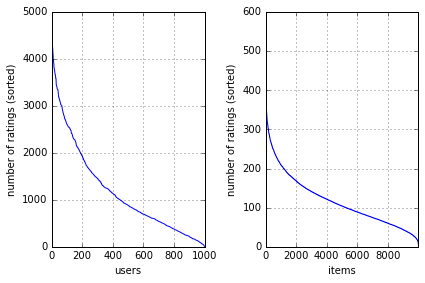

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [4]:
def initialize_matrices_random(train, num_features):
    """
        Initialize randomly matrices W and Z of matrix factorization.

        Arguments:
            train: training set (matrix X)
            num_features: number of latent variables in the W*Z^T decomposition

        Returned value(s):
            item_features: matrix W of shape = num_features, num_item
            user_features: matrix Z of shape = num_features, num_user
    """
    
    # W matrix initialization
    item_features = np.random.random((train.shape[0], num_features))
    # Z matrix initialization
    user_features = np.random.random((train.shape[1], num_features))
    
    return item_features, user_features

In [5]:
def initialize_matrices_first_column_mean(train, num_features):
    """
        Initialize randomly matrices W and Z of matrix factorization.
        In matrix W first column is assigned to average rating for that movie.

        Arguments:
            train: training set (matrix X)
            num_features: number of latent variables in the W*Z^T decomposition

        Returned value(s):
            item_features: matrix W of shape = num_features, num_item
            user_features: matrix Z of shape = num_features, num_user
    """

    # W matrix initialization
    item_features = np.random.random((train.shape[0], num_features))
    item_features[:, 0] = train.mean(axis=1).reshape(item_features.shape[0])
    # Z matrix initialization
    user_features = np.random.random((train.shape[1], num_features))

    return item_features, user_features

In [6]:
def initialize_matrices_global_mean(train, num_features):
    """
        Initialize matrices W and Z of matrix factorization such that W*Z^T contains global mean
        at all positions. Therefore all elements of W and Z equal to square root of global_mean/num_features

        Arguments:
            train: training set (matrix X)
            num_features: number of latent variables in the W*Z^T decomposition

        Returned value(s):
            item_features: matrix W of shape = num_features, num_item
            user_features: matrix Z of shape = num_features, num_user
    """
    
    global_mean = np.sum(train) / len(train.nonzero()[0])

    # W matrix initialization
    item_features = np.sqrt(global_mean/num_features) * np.ones((train.shape[0], num_features)) 
    # Z matrix initialization
    user_features = np.sqrt(global_mean/num_features) * np.ones((train.shape[1], num_features))
    
    return item_features, user_features

In [7]:
def initialize_matrices_SVD(train, num_features):
    """
        Initialize matrices W and Z of matrix factorization using SVD decomposition of original matrix X.

        Arguments:
            train: training set (matrix X)
            num_features: number of latent variables in the W*Z^T decomposition

        Returned value(s):
            item_features: matrix W of shape = num_features, num_item
            user_features: matrix Z of shape = num_features, num_user
    """
    
    U, s, V = np.linalg.svd(train, full_matrices=False)
    
    S = np.diag(s)

    U_1 = U[:, 0:num_features]
    S_1 = S[0:num_features, 0:num_features]
    V_1 = V[0:num_features, :]
    
    # W matrix initialization
    item_features = U_1
    # Z matrix initialization
    user_features = (S_1.dot(V_1)).T
    
    return item_features, user_features

In [8]:
def compute_ALS(train_set, train_nonzero_indices, test_set, test_nonzero_indices, num_epochs, cutoff, max_iter_threshold, num_features, item_features, user_features, test_mode):
    # initialize matrices used to compute RMSE
    train_label = np.zeros(len(train_nonzero_indices))
    test_label = np.zeros(len(test_nonzero_indices))
    train_prediction_label = np.zeros(len(train_nonzero_indices))
    test_prediction_label = np.zeros(len(test_nonzero_indices))
    
    # initialize accumulators for RMSE of every iteration
    train_rmse = np.zeros(num_epochs)
    test_rmse = np.zeros(num_epochs)
    if test_mode == True:
        for i in range(len(test_nonzero_indices)):
            test_label[i] = test_set[test_nonzero_indices[i][0], test_nonzero_indices[i][1]]
    
    lambda_user_diag = np.identity(num_features)
    np.fill_diagonal(lambda_user_diag, lambda_user)
    lambda_item_diag = np.identity(num_features)
    np.fill_diagonal(lambda_item_diag, lambda_user)
    
    last_train_rmse = 0
    
    for it in range(num_epochs):
        begin = datetime.datetime.now() # start time measurement
        
        print("Epoch:", it)

        # perform one iteteration of the algorithm
        
        # first fix item features: Z^T = (W^T*W + (lambda_z*I_K)^(-1)*W^T*X)
        user_features = (np.linalg.inv(item_features.T.dot(item_features) + lambda_user_diag).dot(item_features.T.dot(train_set))).T
        # then fix user features: W^T = (Z^T*Z + (lambda_w*I_K)^(-1)*Z^T*X^T)
        item_features = (np.linalg.inv(user_features.T.dot(user_features) + lambda_item_diag).dot(user_features.T.dot(train_set.T))).T

        # calculate training RMSE
        for i in range(len(train_nonzero_indices)):
            train_label[i] = train_set[train_nonzero_indices[i][0], train_nonzero_indices[i][1]]
            train_prediction_label[i] = item_features[train_nonzero_indices[i][0], :].dot(user_features.T[:, train_nonzero_indices[i][1]])
        
        # store train RMSE of current iteration
        train_rmse[it] = calculate_mse(train_label, train_prediction_label)
        
        print("RMSE on training set:", train_rmse[it])
        
        if test_mode == True:
            # calculate test RMSE
            for i in range(len(test_nonzero_indices)):
                test_prediction_label[i] = item_features[test_nonzero_indices[i][0], :].dot(user_features.T[:, test_nonzero_indices[i][1]])

            # store test RMSE of current iteration
            test_rmse[it] = calculate_mse(test_label, test_prediction_label)

            print("RMSE on test set:", test_rmse[it])

        end = datetime.datetime.now() # stop time measurement
        
        # compute the time of the iteration
        execution_time = (end - begin).total_seconds()
        print("Execution time:", execution_time)

        print("*" * 50)
        
        if np.fabs(last_train_rmse - train_rmse[it]) < max_iter_threshold:
            print("ALREADY")
            if cutoff == True:
                break
        else:
            last_train_rmse = train_rmse[it]
    
    return item_features.dot(user_features.T), train_rmse, test_rmse, it

In [9]:
# set random seed
np.random.seed(888)

# define parameters
init_method_num = 1 # number of matrices initialization method
num_epochs = 100 # number of iterations of ALS
cutoff = False # setting for usage of max_iter_threshold stop condition
max_iter_threshold = 0.00005 # stop condition for ALS algorithm, no visible improvement
num_features = 50 # number of latent features in matrix factorization
lambda_item = 60 # regularization parameter for item features
lambda_user = 10 # regularization parameter for user features
split_ratio = 1.0 # ratio between size of training and test set
test_mode = True
if split_ratio == 1.0:
    test_mode = False

def nonzero_indices(matrix):
    nz_row, nz_col = matrix.nonzero()
    return list(zip(nz_row, nz_col))

# find the non-zero ratings indices in the training set
nonzero_indices = nonzero_indices(ratings)

# convert sparse matrix representation to dense matrix representation
ratings_dense = scipy.sparse.lil_matrix.todense(ratings)

# preprocessing
initialize_methods = [initialize_matrices_random, initialize_matrices_first_column_mean, initialize_matrices_global_mean, initialize_matrices_SVD]
item_features, user_features = None, None

if init_method_num != 2:
    # initialize matrices W and Z
    item_features, user_features = initialize_methods[init_method_num](ratings_dense, num_features)

# normalize rows of ratings matrix by substracting mean (bias) rating for each movie
h = np.nanmean(np.where(ratings_dense != 0, ratings_dense, np.nan), axis = 0)
for i, j in nonzero_indices:
    ratings_dense[i, j] -= h[j]

# normalize columns of ratings matrix by substracting mean (bias) rating for each users
v = np.nanmean(np.where(ratings_dense != 0, ratings_dense, np.nan), axis = 1)
for i, j in nonzero_indices:
    ratings_dense[i, j] -= v[i]

if init_method_num == 2:
    # initialize matrices W and Z
    item_features, user_features = initialize_methods[init_method_num](ratings_dense, num_features)

# split data into training and test sets
np.random.shuffle(nonzero_indices)

split_point = int(np.floor(len(nonzero_indices) * split_ratio))
train_nonzero_indices = nonzero_indices[:split_point]
test_nonzero_indices = nonzero_indices[split_point:]

train_set = np.zeros(ratings_dense.shape)
test_set = np.zeros(ratings_dense.shape)

for i, j in train_nonzero_indices:
    train_set[i, j] = ratings_dense[i, j]

for i, j in test_nonzero_indices:
    test_set[i, j] = ratings_dense[i, j]

# compute the prediction and errors
prediction, train_rmse, test_rmse, num_iter = compute_ALS(train_set, train_nonzero_indices, test_set, test_nonzero_indices, num_epochs, cutoff, max_iter_threshold, num_features, item_features, user_features, test_mode)

Epoch: 0
RMSE on training set: 0.987939023755
Execution time: 6.631406
**************************************************
Epoch: 1
RMSE on training set: 0.901150818631
Execution time: 6.450634
**************************************************
Epoch: 2
RMSE on training set: 0.888434744609
Execution time: 6.56809
**************************************************
Epoch: 3
RMSE on training set: 0.88483451742
Execution time: 6.392751
**************************************************
Epoch: 4
RMSE on training set: 0.883383315355
Execution time: 6.56982
**************************************************
Epoch: 5
RMSE on training set: 0.882720365411
Execution time: 6.52346
**************************************************
Epoch: 6
RMSE on training set: 0.882387965847
Execution time: 6.623516
**************************************************
Epoch: 7
RMSE on training set: 0.882209636636
Execution time: 6.372072
**************************************************
Epoch: 8
RMSE on training se

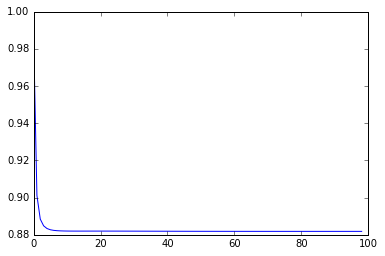

In [10]:
if test_mode == True:
    plt.plot(range(num_iter), train_rmse[:num_iter], range(num_iter), test_rmse[:num_iter])
else:
    plt.plot(range(num_iter), train_rmse[:num_iter])

In [11]:
def create_csv_submission(prediction, submission_file_path = "submission.csv"):
    """
        Creates an output file in csv format for submission to kaggle.

        Arguments:
            prediction: matrix W * Z^T
            submission_file_path: string name of .csv output file to be created
    """

    dataset_file_path = "sampleSubmission.csv" # file path to the dataset of the entries to be predicted
    sample_ratings = load_data(dataset_file_path)
    
    # find the non-zero ratings indices 
    nz_row_sr, nz_col_sr = sample_ratings.nonzero()
    nz_sr = list(zip(nz_row_sr, nz_col_sr))
    
    def trim_values(x):
        if x < 1:
            return 1
        if x > 5:
            return 5
        return x
    
    def discretize_values(x):
        if x <= 1.5:
            return 1
        if x <= 2.5:
            return 2
        if x <= 3.5:
            return 3
        if x <= 4.5:
            return 4
        return 5
    
    submission_file_path = time.strftime("%Y%m%d_%H%M%S") + " " + submission_file_path
    with open(submission_file_path, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for i, j in nz_sr:
            writer.writerow({'Id' : 'r' + str(i + 1) + '_' + 'c' + str(j + 1),
                             'Prediction' : str(trim_values(prediction[i, j]))})

In [12]:
# denormalize rows of ratings matrix by adding back mean (bias) rating for each movie
H = np.zeros(prediction.shape)
for i in range(prediction.shape[0]):
    H[i, :] = h

# denormalize columns of ratings matrix by adding back mean (bias) rating for each user
V = np.zeros(prediction.shape)
for i in range(prediction.shape[1]):
    V[:, i] = v

prediction = prediction + H + V

if test_mode == False:
    create_csv_submission(prediction)

number of items: 10000, number of users: 1000
